# Create the dataset

In [1]:
import dataset
from torchvision import transforms

IMG_SIZE=224

train_transform = transforms.Compose([
    dataset.SquarePad(fill=255),
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])

test_validate_transform = transforms.Compose([
    dataset.SquarePad(fill=255),
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])

train_dataloader, test_dataloader, validate_dataloader, names = dataset.create_dataloaders(
    train_transform=train_transform,
    test_transform=test_validate_transform,
    validate_transform=test_validate_transform,
)

print(names)



/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['RG01 RX-78-2 Gundam', "RG02 MS-06S Char's Zaku II", 'RG03 GAT-X-105 Aile Strike Gundam', 'RG04 MS-06F Zaku II', 'RG05 ZGMF-X10A Freedom Gundam', 'RG06 FX-550 Sky Grasper', 'RG07 RX-178 Gundam Mk-II Titans', 'RG08 RX-178 Gundam Mk-II A.E.U.G.', 'RG09 ZGMF-X09A Justice Gundam', 'RG10 MSZ-006 Zeta Gundam', 'RG11 ZGMF-X42S Destiny Gundam', 'RG12 RX-78GP01 Zephyranthes', 'RG13 RX-78GP01fb Full Burnern', 'RG14 ZGMF-X20A Strike Freedom Gundam', 'RG15 GN-001 Gundam Exia', "RG16 MSM-07S Char's Z'gok", 'RG17 XXXG-00W0 Wing Gundam Zero EW', 'RG18 GN-0000-GNR-010 OO Raiser', 'RG19 MBF-P02 Gundam Astray Red Frame', 'RG20 XXXG-01W Wing Gundam EW', 'RG21 GNT-0000 OO Qan[T]', 'RG22 MSN-06S Sinanju', 'RG23 Build Strike Gundam Full Package', 'RG24 Gundam Astray Gold Frame Amatsu Mina', 'RG25 RX-0 Unicorn Gundam', "RG26 MS-06R-2 Johnny Ridden's Zaku II", 'RG27 RX-0[N] Unicorn Gundam 02 Banshee Norn', 'RG28 OZ-00MS Tallgeese EW', 'RG29 MSN-04 Sazabi', 'RG30 RX-0 Full Armor Unicorn Gundam', 'RG31 XM-X1 C

In [2]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(6))

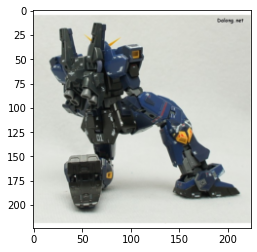

In [3]:
import data_utils

data_utils.plot_image(image)

# ViT Equations

\begin{aligned}
\mathbf{z}_0 &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{p o s}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{p o s} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}

# Equation 1: Split data into patches and creating the class, position and patch embedding

## Image patch

In [4]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


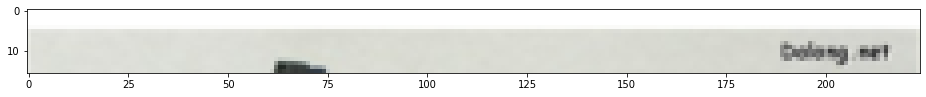

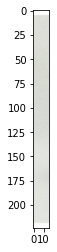

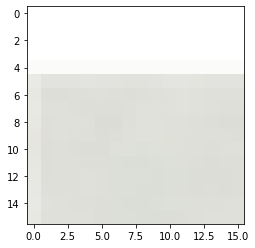

In [5]:
import matplotlib.pyplot as plt

# Change image shape to be compatible with matplotlib (color_channels, height, width) -> (height, width, color_channels) 
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);
plt.show()

plt.imshow(image_permuted[:, :patch_size, :]);
plt.show()

plt.imshow(image_permuted[:patch_size, :patch_size, :]);
plt.show()

Image size: 224 x 224        
Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


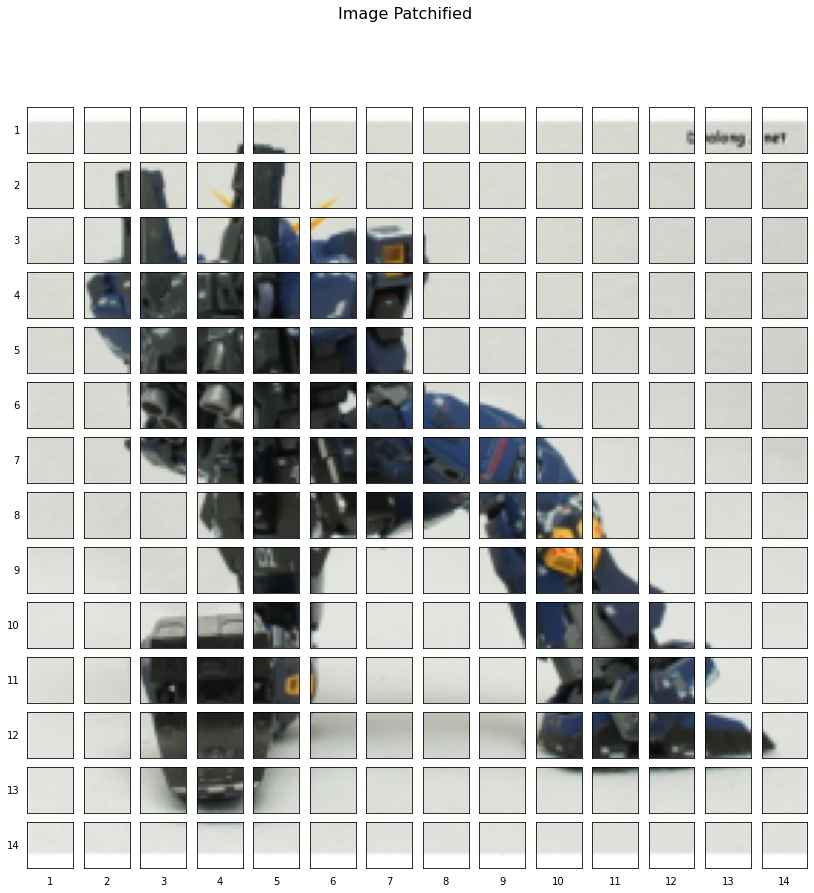

In [6]:
import importlib
importlib.reload(data_utils)

PATCH_SIZE=16
data_utils.plot_patched_image(image, PATCH_SIZE)

## Step by Step

### Step 1 Conv2D

Witch `kernel_size` and `strid` equal to patch size (16 here) conv `[N, 3, 224, 224]` images into `[N, 768, 14, 14]`, where:
- patch size 16, it's a hyper parameter
- 768 is the embedding size, also a hyper parameter

In [7]:
from torch import nn

conv2d = nn.Conv2d(in_channels=3,
                  out_channels=768,
                  kernel_size=PATCH_SIZE,
                  stride=PATCH_SIZE,
                  padding=0)

In [9]:
img_out_of_conv = conv2d(image.unsqueeze(0))
print (img_out_of_conv.shape) # [batch_size, embedding_dim, feature_map_height, feature_map_width]

torch.Size([1, 768, 14, 14])


Showing random convolutional feature maps from indexes: [714, 501, 203, 120, 436]


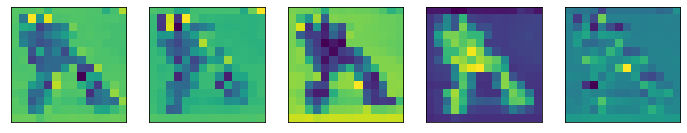

In [10]:
# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 758), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [11]:
# Current tensor shape
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


### Step 2 Flatten

Flatten the last 2 dimensions [14, 14] into one [196] 

In [12]:
flatten = nn.Flatten(start_dim=2, end_dim=3)
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(image_out_of_conv_flattened.shape)

torch.Size([1, 768, 196])


### Step 3 Rearrange the dimensions

In [13]:
# Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


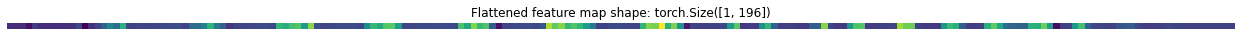

In [14]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)
# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

### Putting all together

`[N, 224, 224, 3]` => `[N, 196, 768]`

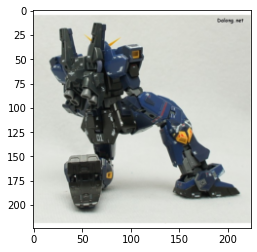

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])
Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


In [15]:
# 1. View single image
data_utils.plot_image(image)
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

# 4. Get flattened image patch embeddings in right shape 
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

## PatchEmbedding

In [16]:
# 1. Create a class which subclasses nn.Module
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.
    
    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """ 
    # 2. Initialize the class with appropriate variables
    def __init__(self, 
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()
        
        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method 
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisble by patch size, image shape: {image_resolution}, patch size: {patch_size}"
        
        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched) 
        # 6. Make sure the output shape has the right order 
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [17]:
import utils
utils.set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])


In [18]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)

# # Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
utils.summary(PatchEmbedding(), input_size=random_input_image)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

## class token embedding

In [19]:
# View the patch embedding and patch embedding shape
print(patch_embedded_image) 
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[-0.9074,  0.2485, -0.1941,  ...,  0.7232, -0.4948,  0.3046],
         [-0.9017,  0.2474, -0.2000,  ...,  0.7222, -0.4931,  0.3050],
         [-0.9057,  0.2503, -0.1967,  ...,  0.7270, -0.4924,  0.3024],
         ...,
         [-0.9185,  0.2723, -0.3342,  ...,  0.7595, -0.4274,  0.3389],
         [-0.9279,  0.2747, -0.3369,  ...,  0.7548, -0.4287,  0.3373],
         [-0.9222,  0.2785, -0.3378,  ...,  0.7588, -0.4335,  0.3375]]],
       grad_fn=<PermuteBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [23]:
import torch

# Get the batch size and embedding dimension [1, 196, 768]
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

# Create the class token embedding as a learnable parameter that shares the same size as the embedding dimension (D)
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension), # [batch_size, number_of_tokens, embedding_dimension]
                           requires_grad=True) # make sure the embedding is learnable

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


In [25]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image), 
                                                      dim=1) # concat on first dimension

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.9074,  0.2485, -0.1941,  ...,  0.7232, -0.4948,  0.3046],
         [-0.9017,  0.2474, -0.2000,  ...,  0.7222, -0.4931,  0.3050],
         ...,
         [-0.9185,  0.2723, -0.3342,  ...,  0.7595, -0.4274,  0.3389],
         [-0.9279,  0.2747, -0.3369,  ...,  0.7548, -0.4287,  0.3373],
         [-0.9222,  0.2785, -0.3378,  ...,  0.7588, -0.4335,  0.3375]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


## position embedding

In [26]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1, 
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embeddding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embeddding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


adding position embedding to patch embedded image with class embedding

In [27]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.0926, 1.2485, 0.8059,  ..., 1.7232, 0.5052, 1.3046],
         [0.0983, 1.2474, 0.8000,  ..., 1.7222, 0.5069, 1.3050],
         ...,
         [0.0815, 1.2723, 0.6658,  ..., 1.7595, 0.5726, 1.3389],
         [0.0721, 1.2747, 0.6631,  ..., 1.7548, 0.5713, 1.3373],
         [0.0778, 1.2785, 0.6622,  ..., 1.7588, 0.5665, 1.3375]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


##  Putting it all together: from image to embedding

1. Setting the patch size (we'll use 16 as it's widely used throughout the paper and for ViT-Base).
1. Getting a single image, printing its shape and storing its height and width.
1. Adding a batch dimension to the single image so it's compatible with our PatchEmbedding layer.
1. Creating a PatchEmbedding layer (the one we made in section 4.5) with a patch_size=16 and embedding_dim=768 (from Table 1 for ViT-Base).
1. Passing the single image through the PatchEmbedding layer in 4 to create a sequence of patch embeddings.
1. Creating a class token embedding like in section 4.6.
1. Prepending the class token emebdding to the patch embeddings created in step 5.
1. Creating a position embedding like in section 4.7.
1. Adding the position embedding to the class token and patch embeddings created in step 7.

In [28]:
utils.set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"2. Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"3. Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"5. Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"6. Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"7. Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"9. Patch and position embedding shape: {patch_and_position_embedding.shape}")

2. Image tensor shape: torch.Size([3, 224, 224])
3. Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
5. Patching embedding shape: torch.Size([1, 196, 768])
6. Class token embedding shape: torch.Size([1, 1, 768])
7. Patch embedding with class token shape: torch.Size([1, 197, 768])
9. Patch and position embedding shape: torch.Size([1, 197, 768])


# Equation 2: Multi-Head Attention (MSA) 

1. Create a class called MultiheadSelfAttentionBlock that inherits from torch.nn.Module.
1. Initialize the class with hyperparameters from Table 1 of the ViT paper for the ViT-Base model.
1. Create a layer normalization (LN) layer with torch.nn.LayerNorm() with the normalized_shape parameter the same as our embedding dimension (D from Table 1).
1. Create a multi-head attention (MSA) layer with the appropriate embed_dim, num_heads, dropout and batch_first parameters.
1.  Create a forward() method for our class passing the in the inputs through the LN layer and MSA layer.

In [29]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:int=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?
        
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings 
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output
        

In [30]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1 
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


In [31]:
utils.summary(multihead_self_attention_block, input_size=[1, 197, 768])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MultiheadSelfAttentionBlock (MultiheadSelfAttentionBlock)    [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (layer_norm)                                     [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (multihead_attn)                        --                   [1, 197, 768]        2,362,368            True
Total params: 2,363,904
Trainable params: 2,363,904
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.61
Forward/backward pass size (MB): 1.21
Params size (MB): 0.01
Estimated Total Size (MB): 1.82

# Equation 3: Multilayer Perceptron (MLP)

1. Create a class called MLPBlock that inherits from torch.nn.Module.
1. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
1. Create a layer normalization (LN) layer with torch.nn.LayerNorm() with the normalized_shape parameter the same as our embedding dimension (D from Table 1).
1. Create a sequential series of MLP layers(s) using torch.nn.Linear(), torch.nn.Dropout() and torch.nn.GELU() with appropriate hyperparameter values from Table 1 and Table 3.
1. Create a forward() method for our class passing the in the inputs through the LN layer and MLP layer(s).

In [32]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:int=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()
        
        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        
        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )
    
    # 5. Create a forward() method to pass the data throguh the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [33]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1 
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_mlp_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


In [34]:
utils.summary(mlp_block, input_size=[1, 197, 768])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
MLPBlock (MLPBlock)                      [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (layer_norm)                 [1, 197, 768]        [1, 197, 768]        1,536                True
├─Sequential (mlp)                       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─Linear (0)                        [1, 197, 768]        [1, 197, 3072]       2,362,368            True
│    └─GELU (1)                          [1, 197, 3072]       [1, 197, 3072]       --                   --
│    └─Dropout (2)                       [1, 197, 3072]       [1, 197, 3072]       --                   --
│    └─Linear (3)                        [1, 197, 3072]       [1, 197, 768]        2,360,064            True
│    └─Dropout (4)                       [1, 197, 768]        [1, 197, 768]        --                   --
Total params: 4,723,

# Transformer Encoder

1. Create a class called TransformerEncoderBlock that inherits from torch.nn.Module.
1. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
1. Instantiate a MSA block for equation 2 using our MultiheadSelfAttentionBlock from section 5.2 with the appropriate parameters.
1. Instantiate a MLP block for equation 3 using our MLPBlock from section 6.2 with the appropriate parameters.
1. Create a forward() method for our TransformerEncoderBlock class.
1. Create a residual connection for the MSA block (for equation 2).
1. Create a residual connection for the MLP block (for equation 3).

In [35]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:int=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:int=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        
        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)
        
    # 5. Create a forward() method  
    def forward(self, x):
        
        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x 
        
        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x 
        
        return x

In [36]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()
transformer_encoder_block



TransformerEncoderBlock(
  (msa_block): MultiheadSelfAttentionBlock(
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (multihead_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
    )
  )
  (mlp_block): MLPBlock(
    (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (mlp): Sequential(
      (0): Linear(in_features=768, out_features=3072, bias=True)
      (1): GELU(approximate=none)
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=3072, out_features=768, bias=True)
      (4): Dropout(p=0.1, inplace=False)
    )
  )
)

In [37]:
# # Print an input and output summary of our Transformer Encoder (uncomment for full output)
utils.summary(model=transformer_encoder_block,
         input_size=(1, 197, 768))

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

## Pytorch's Transformer layers

In [38]:
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(
    d_model=768, # Hidden size D from Table 1 for ViT-Base
    nhead=12, # Heads from Table 1 for ViT-Base
    dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
    dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
    activation="gelu", # GELU non-linear activation
    batch_first=True,  # Do our batches come first?
    norm_first=True, # Normalize first or after MSA/MLP layers?
)
torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [40]:
utils.summary(model=torch_transformer_encoder_layer,
         input_size=(1, 197, 768))

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

# ViT

1. Create a class called `ViT` that inherits from `torch.nn.Module`.
2. Initialize the class with hyperparameters from Table 1 and Table 3 of the ViT paper for the ViT-Base model.
3. Make sure the image size is divisible by the patch size (the image should be split into even patches).
4. Calculate the number of patches using the formula $N=H W / P^{2}$, where $H$ is the image height, $W$ is the image width and $P$ is the patch size.
5. Create a learnable class embedding token (equation 1) as done above in section 4.6.
6. Create a learnable position embedding vector (equation 1) as done above in section 4.7.
7. Setup the embedding dropout layer as discussed in Appendix B.1 of the ViT paper.
8. Create the patch embedding layer using the `PatchEmbedding` class as above in section 4.5.
9. Create a series of Transformer Encoder blocks by passing a list of `TransformerEncoderBlock`s created in section 7.1 to `torch.nn.Sequential()` (equations 2 & 3).
10. Create the MLP head (also called classifier head or equation 4) by passing a `torch.nn.LayerNorm()` (LN) layer and a `torch.nn.Linear(out_features=num_classes)` layer (where `num_classes` is the target number of classes) linear layer to `torch.nn.Sequential()`.
11. Create a `forward()` method that accepts an input.
12. Get the batch size of the input (the first dimension of the shape).
13. Create the patching embedding using the layer created in step 8 (equation 1).
14. Create the class token embedding using the layer created in step 5 and expand it across the number of batches found in step 11 using [`torch.Tensor.expand()`](https://pytorch.org/docs/stable/generated/torch.Tensor.expand.html) (equation 1).
15. Concatenate the class token embedding created in step 13 to the first dimension of the patch embedding created in step 12 using [`torch.cat()`](https://pytorch.org/docs/stable/generated/torch.cat.html) (equation 1).
16. Add the position embedding created in step 6 to the patch and class token embedding created in step 14 (equation 1). 
17. Pass the patch and position embedding through the dropout layer created in step 7.
18. Pass the patch and position embedding from step 16 through the stack of Transformer Encoder layers created in step 9 (equations 2 & 3).
19. Pass index 0 of the output of the stack of Transformer Encoder layers from step 17 through the classifier head created in step 10 (equation 4).
20. Dance and shout woohoo!!! We just built a Vision Transformer!

In [41]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:int=0, # Dropout for attention projection
                 mlp_dropout:int=0.1, # Dropout for dense/MLP layers 
                 embedding_dropout:int=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!
        
        # 3. Make the image size is divisble by the patch size 
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."
        
        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
                 
        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)
        
        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)
                
        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        
        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)
        
        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential()) 
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
       
        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
    # 11. Create a forward() method
    def forward(self, x):
        
        # 12. Get batch size
        batch_size = x.shape[0]
        
        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1) 
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x       

In [42]:
t=torch.randn(1, 5)
print(t)
print(t.expand(3, -1))


tensor([[-0.4311,  0.6218,  1.6640,  0.2957,  1.2084]])
tensor([[-0.4311,  0.6218,  1.6640,  0.2957,  1.2084],
        [-0.4311,  0.6218,  1.6640,  0.2957,  1.2084],
        [-0.4311,  0.6218,  1.6640,  0.2957,  1.2084]])


In [43]:
utils.set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.3359,  0.4892,  1.1896, -0.3401, -1.0837,  0.6820, -0.2110,  0.2116,
         -1.0537,  0.3663,  0.4741,  0.5135, -0.6445, -0.0695, -0.8392, -0.5850,
         -0.2187, -0.6888,  0.2034,  0.3151,  0.3520,  0.5664, -0.0793, -0.0300,
          0.5280, -0.3499,  0.5208,  0.6833, -0.1502,  0.0071,  0.0876,  0.3873,
          0.4261,  0.2014,  0.0915, -0.5858, -0.3516]],
       grad_fn=<AddmmBackward0>)

In [44]:
utils.summary (vit, input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [32, 3, 224, 224]    [32, 37]             152,064              True
├─PatchEmbedding (patch_embedding)                           [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                      [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                     [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                           [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           [32, 197, 768]       [32, 197, 768]

## Training

[INFO] Created SummaryWriter, saving to: ./runs/2022-11-17/vit...


  5%|███▊                                                                        | 1/20 [00:34<10:51, 34.28s/it]

Epoch: 1 | train_loss: 3.9004 | train_acc: 0.0407 | test_loss: 3.6732 | test_acc: 0.0323


 10%|███████▌                                                                    | 2/20 [01:08<10:13, 34.10s/it]

Epoch: 2 | train_loss: 3.6813 | train_acc: 0.0370 | test_loss: 3.6904 | test_acc: 0.0385


 15%|███████████▍                                                                | 3/20 [01:42<09:40, 34.15s/it]

Epoch: 3 | train_loss: 3.6891 | train_acc: 0.0358 | test_loss: 3.6516 | test_acc: 0.0333


 20%|███████████████▏                                                            | 4/20 [02:16<09:04, 34.05s/it]

Epoch: 4 | train_loss: 3.6701 | train_acc: 0.0424 | test_loss: 3.6249 | test_acc: 0.0437


 25%|███████████████████                                                         | 5/20 [02:50<08:30, 34.06s/it]

Epoch: 5 | train_loss: 3.6637 | train_acc: 0.0360 | test_loss: 3.6289 | test_acc: 0.0490


 30%|██████████████████████▊                                                     | 6/20 [03:24<07:57, 34.10s/it]

Epoch: 6 | train_loss: 3.6427 | train_acc: 0.0343 | test_loss: 3.6276 | test_acc: 0.0333


 35%|██████████████████████████▌                                                 | 7/20 [03:58<07:23, 34.10s/it]

Epoch: 7 | train_loss: 3.6265 | train_acc: 0.0393 | test_loss: 3.6247 | test_acc: 0.0490


 40%|██████████████████████████████▍                                             | 8/20 [04:32<06:47, 34.00s/it]

Epoch: 8 | train_loss: 3.6260 | train_acc: 0.0361 | test_loss: 3.6099 | test_acc: 0.0385


 45%|██████████████████████████████████▏                                         | 9/20 [05:06<06:12, 33.85s/it]

Epoch: 9 | train_loss: 3.6251 | train_acc: 0.0363 | test_loss: 3.6034 | test_acc: 0.0458


 50%|█████████████████████████████████████▌                                     | 10/20 [05:39<05:37, 33.71s/it]

Epoch: 10 | train_loss: 3.6130 | train_acc: 0.0436 | test_loss: 3.6026 | test_acc: 0.0396


 55%|█████████████████████████████████████████▎                                 | 11/20 [06:13<05:03, 33.70s/it]

Epoch: 11 | train_loss: 3.6069 | train_acc: 0.0414 | test_loss: 3.5964 | test_acc: 0.0437


 60%|█████████████████████████████████████████████                              | 12/20 [06:46<04:28, 33.58s/it]

Epoch: 12 | train_loss: 3.6041 | train_acc: 0.0387 | test_loss: 3.5866 | test_acc: 0.0469


 65%|████████████████████████████████████████████████▊                          | 13/20 [07:19<03:54, 33.53s/it]

Epoch: 13 | train_loss: 3.6001 | train_acc: 0.0424 | test_loss: 3.5830 | test_acc: 0.0479


 70%|████████████████████████████████████████████████████▌                      | 14/20 [07:53<03:20, 33.48s/it]

Epoch: 14 | train_loss: 3.5930 | train_acc: 0.0455 | test_loss: 3.5791 | test_acc: 0.0406


 75%|████████████████████████████████████████████████████████▎                  | 15/20 [08:26<02:47, 33.43s/it]

Epoch: 15 | train_loss: 3.5950 | train_acc: 0.0457 | test_loss: 3.5791 | test_acc: 0.0479


 80%|████████████████████████████████████████████████████████████               | 16/20 [08:59<02:13, 33.38s/it]

Epoch: 16 | train_loss: 3.5874 | train_acc: 0.0481 | test_loss: 3.5759 | test_acc: 0.0448


 85%|███████████████████████████████████████████████████████████████▊           | 17/20 [09:33<01:40, 33.41s/it]

Epoch: 17 | train_loss: 3.5868 | train_acc: 0.0427 | test_loss: 3.5747 | test_acc: 0.0437


 90%|███████████████████████████████████████████████████████████████████▌       | 18/20 [10:06<01:06, 33.43s/it]

Epoch: 18 | train_loss: 3.5832 | train_acc: 0.0402 | test_loss: 3.5742 | test_acc: 0.0479


 95%|███████████████████████████████████████████████████████████████████████▎   | 19/20 [10:40<00:33, 33.48s/it]

Epoch: 19 | train_loss: 3.5838 | train_acc: 0.0487 | test_loss: 3.5766 | test_acc: 0.0479


100%|███████████████████████████████████████████████████████████████████████████| 20/20 [11:13<00:00, 33.67s/it]

Epoch: 20 | train_loss: 3.5823 | train_acc: 0.0480 | test_loss: 3.5773 | test_acc: 0.0490
Saving model to: ./models/vit.pt


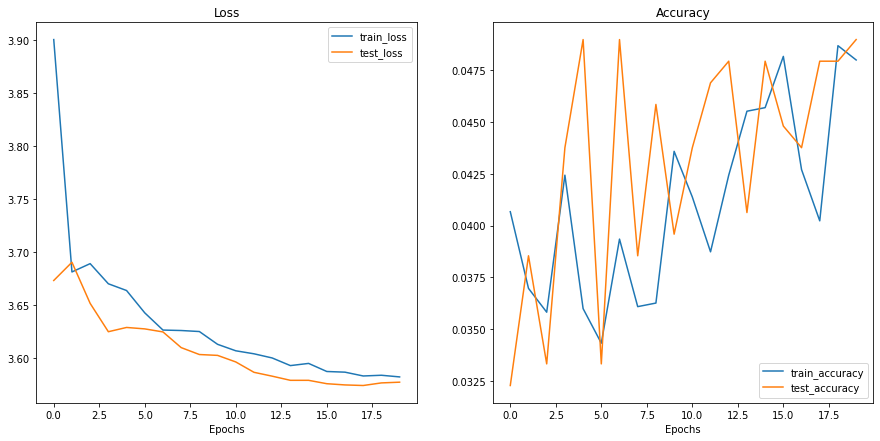

In [45]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper 
optimizer = torch.optim.Adam(params=vit.parameters(), 
                             lr=1e-3, # Base LR from Table 3 
                             betas=(0.9, 0.999), # default values but also mentioned in ViT paper section 4.1 (Training & Fine-tuning)
                             weight_decay=0.1) # from the ViT paper section 4.1 (Training & Fine-tuning)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
utils.set_seeds()

device = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS=20

_=utils.train_and_save(
    model=vit,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device,
    epochs=EPOCHS,
    model_name="vit",
)

# Pretained ViT model

## Creating model

In [51]:
import torchvision

# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False
    
utils.summary(pretrained_vit, input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  False
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 19

In [54]:
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
utils.set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(names))

utils.summary(pretrained_vit, input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 37]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

## Create dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


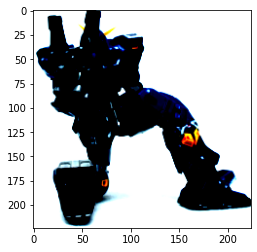

In [59]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

trans_img = pretrained_vit_transforms(image)
data_utils.plot_image(trans_img)

In [60]:
train_dataloader, test_dataloader, validate_dataloader, names = dataset.create_dataloaders(
    train_transform=pretrained_vit_transforms,
    test_transform=pretrained_vit_transforms,
    validate_transform=pretrained_vit_transforms,
)

## Training

[INFO] Created SummaryWriter, saving to: ./runs/2022-11-17/pretrained_vit...


  5%|███▊                                                                        | 1/20 [00:20<06:25, 20.26s/it]

Epoch: 1 | train_loss: 2.7537 | train_acc: 0.3312 | test_loss: 2.0253 | test_acc: 0.5615


 10%|███████▌                                                                    | 2/20 [00:40<06:09, 20.52s/it]

Epoch: 2 | train_loss: 1.5661 | train_acc: 0.6810 | test_loss: 1.5130 | test_acc: 0.6656


 15%|███████████▍                                                                | 3/20 [01:00<05:43, 20.21s/it]

Epoch: 3 | train_loss: 1.1203 | train_acc: 0.7928 | test_loss: 1.2922 | test_acc: 0.6979


 20%|███████████████▏                                                            | 4/20 [01:21<05:24, 20.28s/it]

Epoch: 4 | train_loss: 0.8643 | train_acc: 0.8435 | test_loss: 1.1418 | test_acc: 0.7167


 25%|███████████████████                                                         | 5/20 [01:41<05:02, 20.14s/it]

Epoch: 5 | train_loss: 0.6991 | train_acc: 0.8847 | test_loss: 1.0664 | test_acc: 0.7375


 30%|██████████████████████▊                                                     | 6/20 [02:01<04:43, 20.25s/it]

Epoch: 6 | train_loss: 0.5830 | train_acc: 0.9049 | test_loss: 1.0107 | test_acc: 0.7479


 35%|██████████████████████████▌                                                 | 7/20 [02:21<04:22, 20.18s/it]

Epoch: 7 | train_loss: 0.4916 | train_acc: 0.9376 | test_loss: 0.9492 | test_acc: 0.7604


 40%|██████████████████████████████▍                                             | 8/20 [02:41<04:02, 20.24s/it]

Epoch: 8 | train_loss: 0.4235 | train_acc: 0.9431 | test_loss: 0.9174 | test_acc: 0.7719


 45%|██████████████████████████████████▏                                         | 9/20 [03:02<03:43, 20.33s/it]

Epoch: 9 | train_loss: 0.3640 | train_acc: 0.9620 | test_loss: 0.8930 | test_acc: 0.7656


 50%|█████████████████████████████████████▌                                     | 10/20 [03:22<03:22, 20.29s/it]

Epoch: 10 | train_loss: 0.3163 | train_acc: 0.9679 | test_loss: 0.8811 | test_acc: 0.7656


 55%|█████████████████████████████████████████▎                                 | 11/20 [03:43<03:03, 20.37s/it]

Epoch: 11 | train_loss: 0.2781 | train_acc: 0.9789 | test_loss: 0.8628 | test_acc: 0.7750


 60%|█████████████████████████████████████████████                              | 12/20 [04:03<02:42, 20.37s/it]

Epoch: 12 | train_loss: 0.2446 | train_acc: 0.9842 | test_loss: 0.8429 | test_acc: 0.7656


 65%|████████████████████████████████████████████████▊                          | 13/20 [04:23<02:21, 20.27s/it]

Epoch: 13 | train_loss: 0.2178 | train_acc: 0.9912 | test_loss: 0.8303 | test_acc: 0.7802


 70%|████████████████████████████████████████████████████▌                      | 14/20 [04:44<02:02, 20.38s/it]

Epoch: 14 | train_loss: 0.1921 | train_acc: 0.9938 | test_loss: 0.8249 | test_acc: 0.7792


 75%|████████████████████████████████████████████████████████▎                  | 15/20 [05:04<01:41, 20.40s/it]

Epoch: 15 | train_loss: 0.1747 | train_acc: 0.9947 | test_loss: 0.8140 | test_acc: 0.7781


 80%|████████████████████████████████████████████████████████████               | 16/20 [05:25<01:22, 20.61s/it]

Epoch: 16 | train_loss: 0.1557 | train_acc: 0.9974 | test_loss: 0.8084 | test_acc: 0.7812


 85%|███████████████████████████████████████████████████████████████▊           | 17/20 [05:46<01:02, 20.70s/it]

Epoch: 17 | train_loss: 0.1410 | train_acc: 0.9967 | test_loss: 0.7945 | test_acc: 0.7823


 90%|███████████████████████████████████████████████████████████████████▌       | 18/20 [06:06<00:41, 20.55s/it]

Epoch: 18 | train_loss: 0.1273 | train_acc: 0.9982 | test_loss: 0.7997 | test_acc: 0.7802


 95%|███████████████████████████████████████████████████████████████████████▎   | 19/20 [06:27<00:20, 20.49s/it]

Epoch: 19 | train_loss: 0.1160 | train_acc: 0.9982 | test_loss: 0.7943 | test_acc: 0.7771


100%|███████████████████████████████████████████████████████████████████████████| 20/20 [06:47<00:00, 20.39s/it]

Epoch: 20 | train_loss: 0.1063 | train_acc: 0.9987 | test_loss: 0.7769 | test_acc: 0.7854
Saving model to: ./models/pretrained_vit.pt


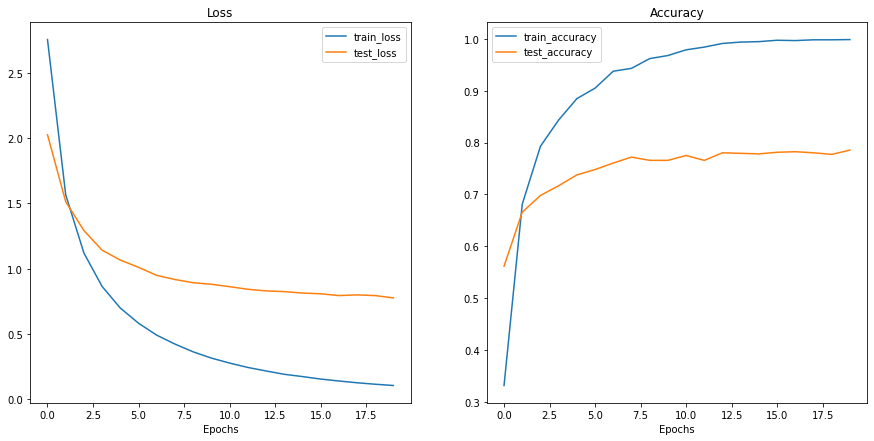

In [63]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
utils.set_seeds()

_=utils.train_and_save(
    model=pretrained_vit,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device,
    epochs=EPOCHS,
    model_name="pretrained_vit",
)

## Evaluate

In [65]:
import engine

metrics=engine.test_step(
    model=pretrained_vit,
    dataloader=validate_dataloader,
    loss_fn=loss_fn,
    device=device,
)

print (metrics)

(1.2094624212809972, 0.6577380952380952)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG31/61QIjQhft-L._AC_SL1200_.jpg
RG31 XM-X1 Crossbone Gundam X1 : 0.483
RG03 GAT-X-105 Aile Strike Gundam : 0.197
RG35 XXXG-01W Wing Gundam : 0.041


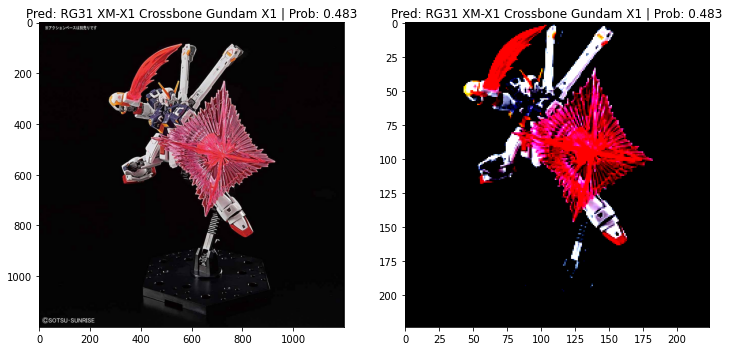

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG29/61csTgm1CdL._AC_SX679_.jpg
RG29 MSN-04 Sazabi   : 0.906
RG22 MSN-06S Sinanju : 0.066
RG16 MSM-07S Char's Z'gok : 0.015


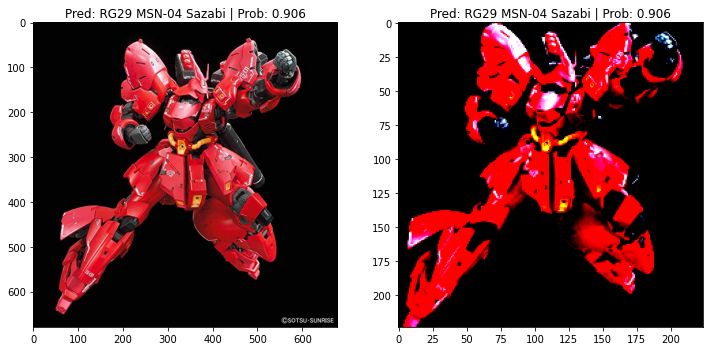

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG06/51svJZfTECL._AC_.jpg
RG18 GN-0000-GNR-010 OO Raiser : 0.215
RG33 ZGMF-X56S_α Force Impulse Gundam : 0.157
RG25 RX-0 Unicorn Gundam : 0.142


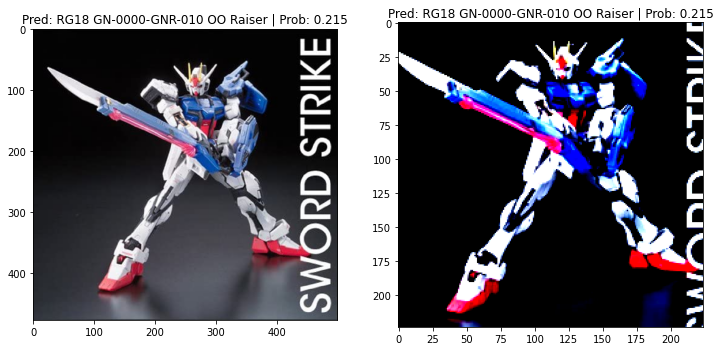

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG11/71EnBOPMHWL._AC_SX679_.jpg
RG05 ZGMF-X10A Freedom Gundam : 0.296
RG17 XXXG-00W0 Wing Gundam Zero EW : 0.177
RG11 ZGMF-X42S Destiny Gundam : 0.142


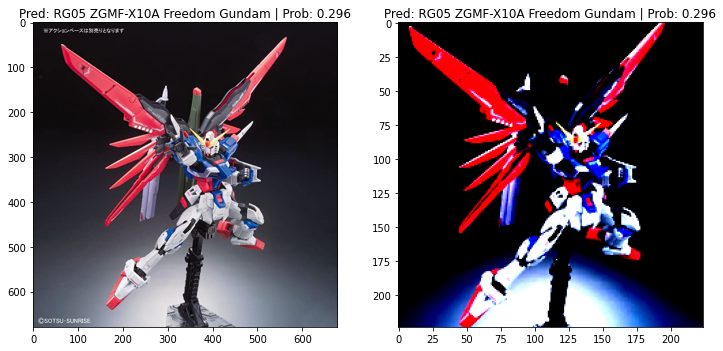

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG27/71F+WSuKoXL._AC_SX679_.jpg
RG27 RX-0[N] Unicorn Gundam 02 Banshee Norn : 0.996
RG24 Gundam Astray Gold Frame Amatsu Mina : 0.001
RG23 Build Strike Gundam Full Package : 0.001


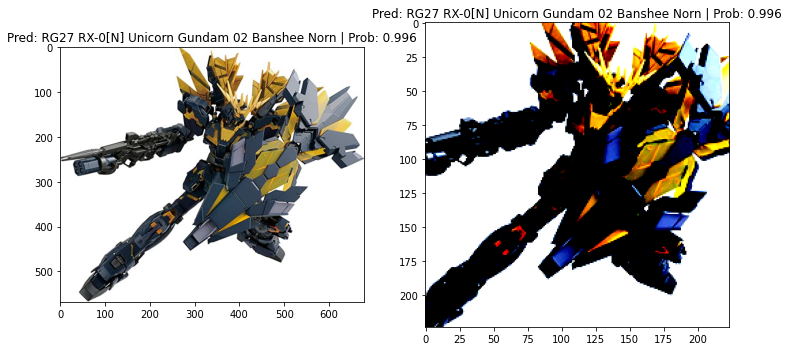

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG32/71garQp8mML._AC_SL1500_.jpg
RG03 GAT-X-105 Aile Strike Gundam : 0.350
RG18 GN-0000-GNR-010 OO Raiser : 0.095
RG28 OZ-00MS Tallgeese EW : 0.094


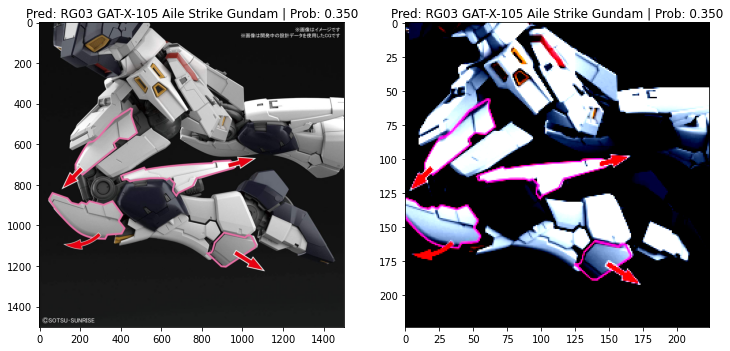

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG06/51SCt6MbYxL._AC_.jpg
RG06 FX-550 Sky Grasper : 0.679
RG25 RX-0 Unicorn Gundam : 0.055
RG03 GAT-X-105 Aile Strike Gundam : 0.043


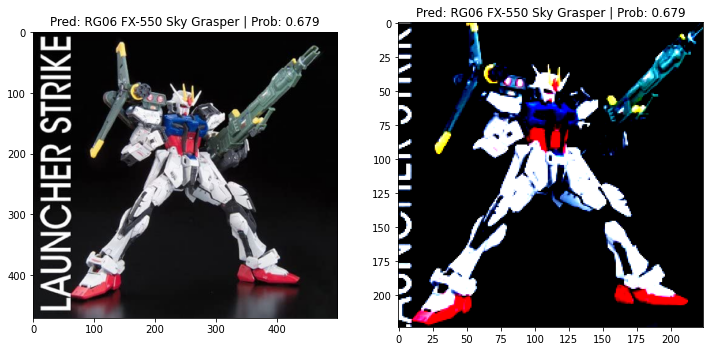

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG32/71L6v9zCZWL._AC_SL1500_.jpg
RG32 RX-93 Nu Gundam : 0.791
RG13 RX-78GP01fb Full Burnern : 0.045
RG08 RX-178 Gundam Mk-II A.E.U.G. : 0.027


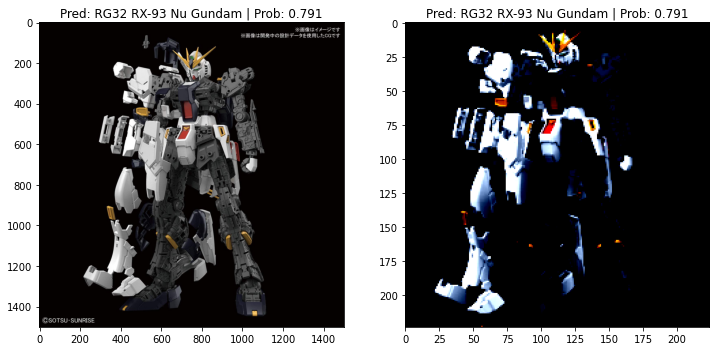

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG34/71LgYPiINoL._AC_SL1500_.jpg
RG34 MSN-02 Zeong    : 0.974
RG08 RX-178 Gundam Mk-II A.E.U.G. : 0.013
RG05 ZGMF-X10A Freedom Gundam : 0.004


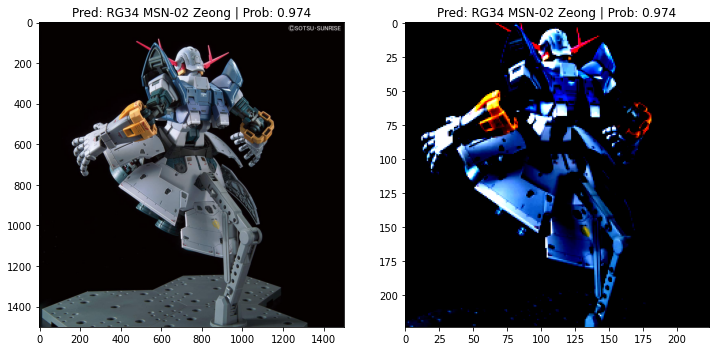

In [68]:
import inference

imgs=data_utils.get_random_images("./data/gunpla/validate", k=9)

for img in imgs:
    print (f"Path {img}")
    inference.predict(
        model=pretrained_vit, 
        image_path=img, 
        class_names=names,
        transform=pretrained_vit_transforms, 
        topk=3)

# Pretained ViT model

## Creating model

In [71]:
import torchvision

# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights2 = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit2 = torchvision.models.vit_b_16(weights=pretrained_vit_weights2)

# 3. Freeze the base parameters
for parameter in pretrained_vit2.parameters():
    parameter.requires_grad = False
    
utils.summary(pretrained_vit2, input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 1000]           768                  False
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 19

In [72]:
# 4. Change the classifier head (set the seeds to ensure same initialization with linear head)
utils.set_seeds()
pretrained_vit2.heads = nn.Linear(in_features=768, out_features=len(names))

utils.summary(pretrained_vit2, input_size=(32, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 37]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

## Create dataset

In [73]:
import dataset
from torchvision import transforms

# Create training transform with TrivialAugment
train_transform = transforms.Compose([
    dataset.SquarePad(fill=255),
    transforms.Resize((224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_validate_transform = transforms.Compose([
    dataset.SquarePad(fill=255),
    transforms.Resize((224,224)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataloader, test_dataloader, validate_dataloader, names = dataset.create_dataloaders(
        train_transform=train_transform,
        test_transform=test_validate_transform,
        validate_transform=test_validate_transform,
    )

## Training

[INFO] Created SummaryWriter, saving to: ./runs/2022-11-17/pretrained_vit2...


  5%|███▊                                                                        | 1/20 [00:21<06:49, 21.53s/it]

Epoch: 1 | train_loss: 2.9436 | train_acc: 0.2727 | test_loss: 2.1901 | test_acc: 0.5188


 10%|███████▌                                                                    | 2/20 [00:42<06:23, 21.30s/it]

Epoch: 2 | train_loss: 1.9533 | train_acc: 0.5587 | test_loss: 1.6867 | test_acc: 0.6104


 15%|███████████▍                                                                | 3/20 [01:03<05:59, 21.17s/it]

Epoch: 3 | train_loss: 1.5357 | train_acc: 0.6601 | test_loss: 1.4569 | test_acc: 0.6625


 20%|███████████████▏                                                            | 4/20 [01:25<05:45, 21.59s/it]

Epoch: 4 | train_loss: 1.2951 | train_acc: 0.7261 | test_loss: 1.2861 | test_acc: 0.6927


 25%|███████████████████                                                         | 5/20 [01:47<05:23, 21.59s/it]

Epoch: 5 | train_loss: 1.1109 | train_acc: 0.7631 | test_loss: 1.1932 | test_acc: 0.7312


 30%|██████████████████████▊                                                     | 6/20 [02:08<05:01, 21.54s/it]

Epoch: 6 | train_loss: 1.0202 | train_acc: 0.7831 | test_loss: 1.1310 | test_acc: 0.7271


 35%|██████████████████████████▌                                                 | 7/20 [02:30<04:38, 21.46s/it]

Epoch: 7 | train_loss: 0.9103 | train_acc: 0.8090 | test_loss: 1.0634 | test_acc: 0.7344


 40%|██████████████████████████████▍                                             | 8/20 [02:51<04:17, 21.49s/it]

Epoch: 8 | train_loss: 0.8327 | train_acc: 0.8226 | test_loss: 1.0383 | test_acc: 0.7469


 45%|██████████████████████████████████▏                                         | 9/20 [03:12<03:54, 21.33s/it]

Epoch: 9 | train_loss: 0.7496 | train_acc: 0.8490 | test_loss: 1.0103 | test_acc: 0.7427


 50%|█████████████████████████████████████▌                                     | 10/20 [03:34<03:33, 21.31s/it]

Epoch: 10 | train_loss: 0.7414 | train_acc: 0.8415 | test_loss: 0.9906 | test_acc: 0.7510


 55%|█████████████████████████████████████████▎                                 | 11/20 [03:55<03:11, 21.27s/it]

Epoch: 11 | train_loss: 0.7053 | train_acc: 0.8447 | test_loss: 0.9493 | test_acc: 0.7573


 60%|█████████████████████████████████████████████                              | 12/20 [04:16<02:50, 21.30s/it]

Epoch: 12 | train_loss: 0.6355 | train_acc: 0.8608 | test_loss: 0.9434 | test_acc: 0.7542


 65%|████████████████████████████████████████████████▊                          | 13/20 [04:37<02:28, 21.22s/it]

Epoch: 13 | train_loss: 0.6180 | train_acc: 0.8755 | test_loss: 0.9207 | test_acc: 0.7490


 70%|████████████████████████████████████████████████████▌                      | 14/20 [04:59<02:08, 21.49s/it]

Epoch: 14 | train_loss: 0.5861 | train_acc: 0.8755 | test_loss: 0.9095 | test_acc: 0.7552


 75%|████████████████████████████████████████████████████████▎                  | 15/20 [05:21<01:47, 21.51s/it]

Epoch: 15 | train_loss: 0.5498 | train_acc: 0.8846 | test_loss: 0.9019 | test_acc: 0.7458


 80%|████████████████████████████████████████████████████████████               | 16/20 [05:42<01:25, 21.40s/it]

Epoch: 16 | train_loss: 0.5146 | train_acc: 0.8918 | test_loss: 0.8947 | test_acc: 0.7510


 85%|███████████████████████████████████████████████████████████████▊           | 17/20 [06:03<01:04, 21.41s/it]

Epoch: 17 | train_loss: 0.5381 | train_acc: 0.8877 | test_loss: 0.8825 | test_acc: 0.7667


 90%|███████████████████████████████████████████████████████████████████▌       | 18/20 [06:25<00:42, 21.33s/it]

Epoch: 18 | train_loss: 0.4898 | train_acc: 0.8925 | test_loss: 0.8740 | test_acc: 0.7656


 95%|███████████████████████████████████████████████████████████████████████▎   | 19/20 [06:46<00:21, 21.26s/it]

Epoch: 19 | train_loss: 0.4648 | train_acc: 0.9050 | test_loss: 0.8685 | test_acc: 0.7646


100%|███████████████████████████████████████████████████████████████████████████| 20/20 [07:07<00:00, 21.37s/it]

Epoch: 20 | train_loss: 0.4528 | train_acc: 0.9065 | test_loss: 0.8462 | test_acc: 0.7698
Saving model to: ./models/pretrained_vit2.pt


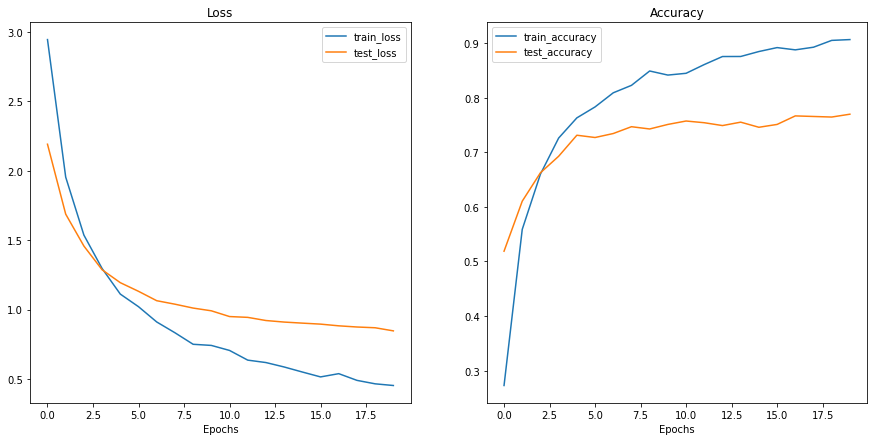

In [74]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit2.parameters(), 
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
utils.set_seeds()

_=utils.train_and_save(
    model=pretrained_vit2,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    device=device,
    epochs=EPOCHS,
    model_name="pretrained_vit2",
)

## Evaluate

In [75]:
import engine

metrics=engine.test_step(
    model=pretrained_vit2,
    dataloader=validate_dataloader,
    loss_fn=loss_fn,
    device=device,
)

print (metrics)

(0.9076529485838754, 0.7410714285714286)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG03/71b28f9bEZL._AC_SX679_.jpg
RG03 GAT-X-105 Aile Strike Gundam : 0.791
RG33 ZGMF-X56S_α Force Impulse Gundam : 0.087
RG09 ZGMF-X09A Justice Gundam : 0.053


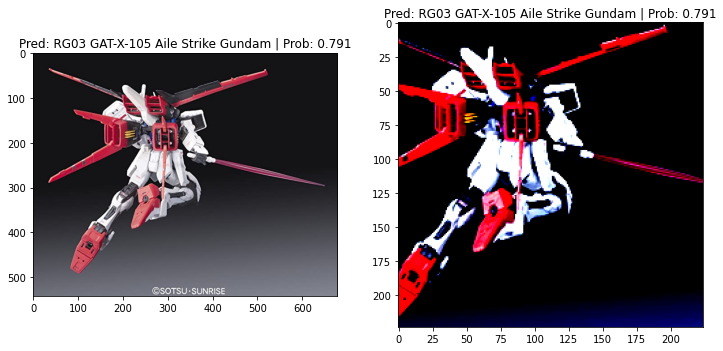

Path data/gunpla/validate/RG04/812CFbHUITL._AC_SX679_.jpg
RG04 MS-06F Zaku II  : 0.996
RG28 OZ-00MS Tallgeese EW : 0.001
RG01 RX-78-2 Gundam  : 0.001


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


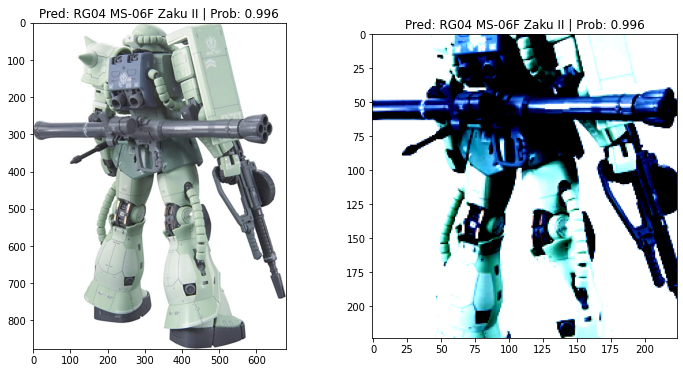

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG14/71tBZkKow6L._AC_SX679_.jpg
RG14 ZGMF-X20A Strike Freedom Gundam : 0.942
RG22 MSN-06S Sinanju : 0.014
RG23 Build Strike Gundam Full Package : 0.012


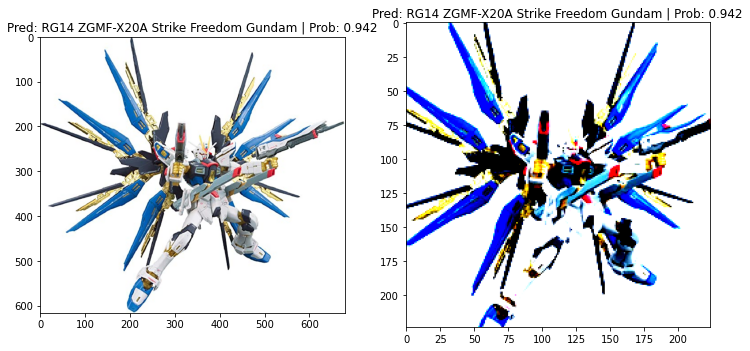

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG10/71ykoD2nAPL._AC_SX679_.jpg
RG10 MSZ-006 Zeta Gundam : 0.789
RG03 GAT-X-105 Aile Strike Gundam : 0.056
RG33 ZGMF-X56S_α Force Impulse Gundam : 0.052


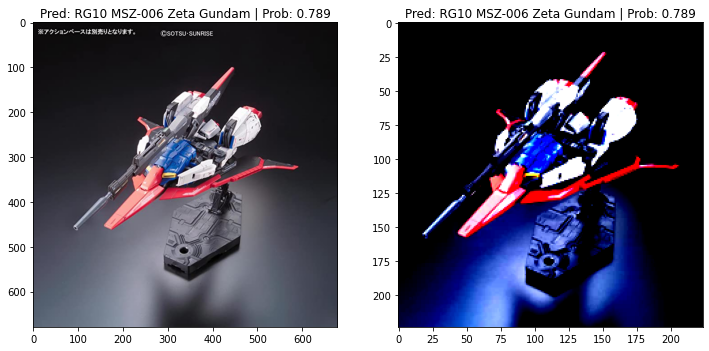

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG21/61LNew5xJJL._AC_SX679_.jpg
RG21 GNT-0000 OO Qan[T] : 0.459
RG15 GN-001 Gundam Exia : 0.132
RG25 RX-0 Unicorn Gundam : 0.065


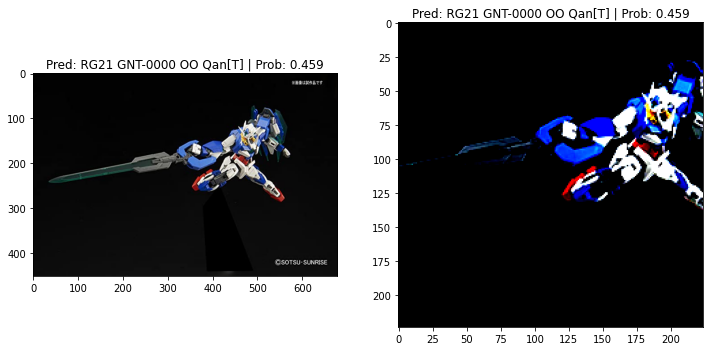

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG36/71hc3vVM4vS._AC_SL1500_.jpg
RG36 RX-93-υ2 Hi-Nu Gundam : 0.967
RG35 XXXG-01W Wing Gundam : 0.007
RG27 RX-0[N] Unicorn Gundam 02 Banshee Norn : 0.006


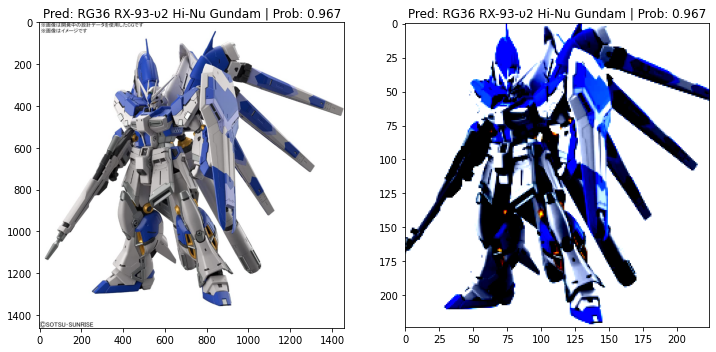

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG28/612ZQp+fxGL._AC_SX679_.jpg
RG22 MSN-06S Sinanju : 0.328
RG05 ZGMF-X10A Freedom Gundam : 0.157
RG28 OZ-00MS Tallgeese EW : 0.099


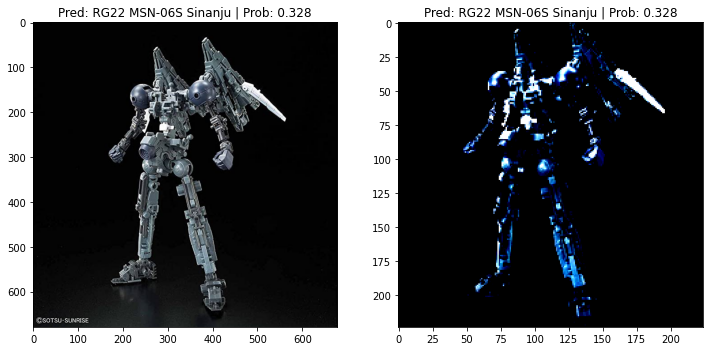

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG07/714voLe8IPL._AC_SX679_.jpg
RG07 RX-178 Gundam Mk-II Titans : 0.788
RG05 ZGMF-X10A Freedom Gundam : 0.046
RG28 OZ-00MS Tallgeese EW : 0.037


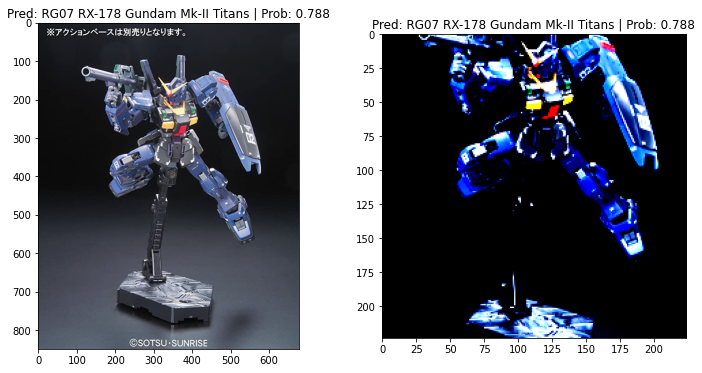

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Path data/gunpla/validate/RG32/61ppE-tpXFL._AC_SL1500_.jpg
RG01 RX-78-2 Gundam  : 0.324
RG10 MSZ-006 Zeta Gundam : 0.138
RG03 GAT-X-105 Aile Strike Gundam : 0.131


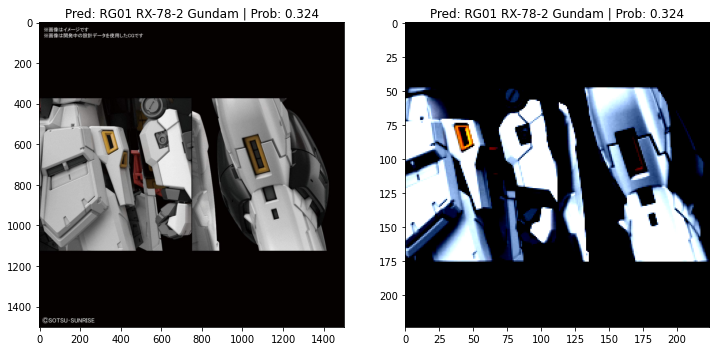

In [77]:
import inference

imgs=data_utils.get_random_images("./data/gunpla/validate", k=9)

for img in imgs:
    print (f"Path {img}")
    inference.predict(
        model=pretrained_vit2, 
        image_path=img, 
        class_names=names,
        transform=pretrained_vit_transforms, 
        topk=3)